## Results Comparison

Top runs:
Accuracy #1: qwen2.5-7b (fewshot) -> 0.8932
Accuracy #2: qwen2.5-7b (selfconsistency) -> 0.8560
Accuracy #3: qwen2.5-7b (meta) -> 0.8528
F1 #1: qwen2.5-7b (fewshot) -> 0.8900
F1 #2: qwen2.5-7b (selfconsistency) -> 0.8463
F1 #3: qwen2.5-7b (meta) -> 0.8428
Saved plot → w4/best_models.png


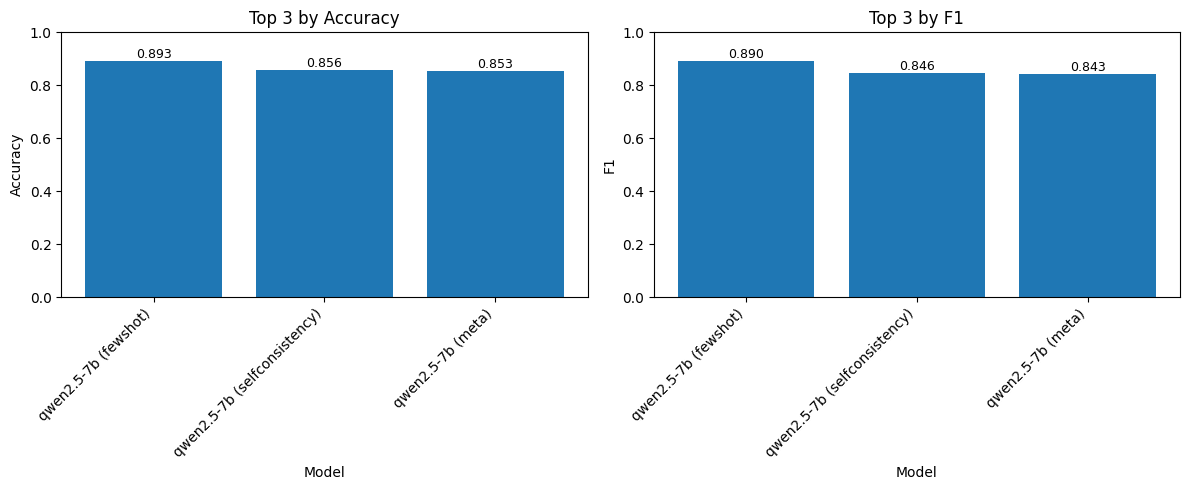

In [ ]:
"""Utility for surfacing the top binary evaluation runs by metric."""
from __future__ import annotations

import json
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List
import os

import matplotlib.pyplot as plt


# Handle both script and notebook execution
try:
    RESULTS_PATH = Path(__file__).resolve().parent / "results" / "binary_results.json"
except NameError:
    # Running in notebook - try multiple possible paths
    current_dir = Path.cwd()
    possible_paths = [
        current_dir / "results" / "binary_results.json",  # If running from 1_LLM_Eval dir
        current_dir / "1_LLM_Eval" / "results" / "binary_results.json",  # If running from project root
    ]
    RESULTS_PATH = None
    for path in possible_paths:
        if path.exists():
            RESULTS_PATH = path
            break
    if RESULTS_PATH is None:
        # Default to relative path from notebook location
        RESULTS_PATH = Path("results") / "binary_results.json"
TOP_K = 3
METRICS = ("Accuracy", "F1")


@dataclass(frozen=True)
class EvalRun:
    label: str
    model_name: str
    prompt_version: str
    metrics: Dict[str, float]

    @classmethod
    def from_entry(cls, entry: Dict) -> "EvalRun":
        model_name = entry['model_name']
        prompt_version = entry['prompt_version']
        label = f"{model_name} ({prompt_version})"
        return cls(label=label, model_name=model_name, prompt_version=prompt_version, metrics=entry.get("metrics", {}))


def load_runs(path: Path) -> List[EvalRun]:
    if not path.exists():
        raise FileNotFoundError(f"Could not find results file at: {path}")

    with path.open() as fp:
        payload = json.load(fp)

    return [EvalRun.from_entry(entry) for entry in payload]


def top_k_runs(runs: List[EvalRun], metric: str, k: int) -> List[EvalRun]:
    filtered = [run for run in runs if metric in run.metrics]
    if not filtered:
        raise ValueError(f"Metric '{metric}' missing from all runs.")

    sorted_runs = sorted(
        filtered,
        key=lambda run: run.metrics[metric],
        reverse=True,
    )
    return sorted_runs[:k]


def plot_top_runs(runs: List[EvalRun], metrics: List[str], top_k: int) -> None:
    fig, axes = plt.subplots(1, len(metrics), figsize=(6 * len(metrics), 5))
    if len(metrics) == 1:
        axes = [axes]

    for ax, metric in zip(axes, metrics):
        top_runs = top_k_runs(runs, metric, top_k)
        scores = [run.metrics[metric] for run in top_runs]
        # Format labels with model name on first line and prompt version on second line
        labels = [f"{run.model_name}\n({run.prompt_version})" for run in top_runs]

        bars = ax.bar(range(len(scores)), scores)
        ax.set_ylim(0, 1)
        ax.set_ylabel(metric)
        ax.set_xlabel("Model")
        ax.set_title(f"Top {len(scores)} by {metric}")
        
        # Set x-axis labels normally (not rotated)
        ax.set_xticks(range(len(scores)))
        ax.set_xticklabels(labels, ha='center')
        
        # Add value labels on top of each bar
        for bar, score in zip(bars, scores):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height,
                   f'{score:.3f}',
                   ha='center', va='bottom', fontsize=9)

    fig.tight_layout()
    
    # Save the plot before showing/closing
    PLOT_DIR = "w4"
    os.makedirs(PLOT_DIR, exist_ok=True)
    save_path = os.path.join(PLOT_DIR, "best_models.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved plot → {save_path}")
    
    plt.show()
    plt.close()


def main() -> None:
    runs = load_runs(RESULTS_PATH)

    print("Top runs:")
    for metric in METRICS:
        best = top_k_runs(runs, metric, TOP_K)
        for idx, run in enumerate(best, start=1):
            print(f"{metric} #{idx}: {run.label} -> {run.metrics[metric]:.4f}")

    plot_top_runs(runs, list(METRICS), TOP_K)


if __name__ == "__main__":
    main()